In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

import pickle
from testsuite.utilities import Pareto_split
import numpy as np
from testsuite.analysis import load_all, plot_all_pareto_2d, PLOT_STYLE, plot_measure
import matplotlib.pyplot as plt

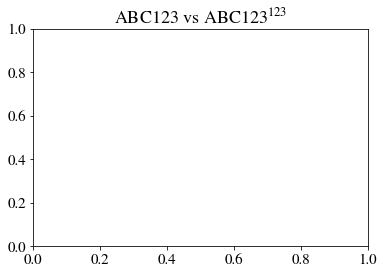

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$');

In [3]:
def plot_measure(results, measure, axis=None, label=None, plot_individuals=False, 
                     color="C0", marker=None): 
    if axis is None: 
        fig = plt.figure(figsize=[12, 8]) 
        axis = fig.gca() 
 
    hvs = results[measure] 
 
    if plot_individuals: 
        for i, hv in enumerate(hvs): 
            # plot idividual results 
            n_inital = results["n_initial"][i] 
            n_total = results["n_evaluations"][i] 
            bo_steps = range(n_inital, n_total + 1) 
            axis.plot(bo_steps, hv, linestyle=":", c=color, alpha=0.4) 
 
    # trim hvs to min length so as to compute mean 
    array_hvs = np.array([hv[:min([len(hv) for hv in hvs])] for hv in hvs]) 
    n_inital = results["n_initial"][0] 
    bo_steps = range(n_inital, array_hvs.shape[1]+n_inital) 
    # plot mean and standard deviations 
    axis.plot(bo_steps, np.median(array_hvs, axis=0), linestyle="-", c=color, 
              alpha=1., label=label, marker = marker, markevery=10) 
    # axis.fill_between(bo_steps, 
    #                   np.mean(array_hvs, axis=0) - np.std(array_hvs, axis=0), 
    #                   np.mean(array_hvs, axis=0) + np.std(array_hvs, axis=0), 
    #                   color=color, alpha=0.2) 
    lower_qa = np.array([np.quantile(i, 0.25) for i in np.array(array_hvs).T]) 
    upper_qa = np.array([np.quantile(i, 0.75) for i in np.array(array_hvs).T]) 
    axis.fill_between(bo_steps, 
                      lower_qa, 
                      upper_qa, 
                      color=color, alpha=0.2) 
 
    if axis is None: 
        return fig 


In [4]:
pkl_dir = "./pkl_data/"
results_dir = "./log_data/"
result_dirs = sorted(os.listdir("./log_data/"))
filename = pkl_dir+'results.pkl'
if not os.path.isdir(pkl_dir):
    os.makedirs(pkl_dir)

In [5]:
try:
    pkl_loaded = True
#     raise FileNotFoundError
    infile = open(filename,'rb')
    results = pickle.load(infile)
    infile.close()
    print("results loaded from ", pkl_dir)
except FileNotFoundError:
    pkl_loaded = False 
    results = []
    for i, result_dir in enumerate(result_dirs):
        result = load_all(os.path.join(results_dir, result_dir))
        name = result_dir.split("_")[2]
        if "ei" in  result_dir:
            name+=" ei"
        elif "mean" in result_dir:
            name+=" $\mu$"
        else:
            pass
        result["name"] = name
        results.append(result)
    print("results loaded from ", results_dir)

for result in results:
    print(result["name"])

results loaded from  ./pkl_data/
Mpoi
ParEgo
Saf ei
Saf $\mu$
SmsEgo ei
SmsEgo $\mu$
lhs


In [6]:
from paralellizer import func, n_obj, test_function, x_limits, n_dim, n_obj

In [7]:
def scatter_nsphere(n_points, n_dims, weighting=None):
    """scatter n_points onto unit n-spere with n_dims dimensions"""
    if weighting is None:
        weighting = np.ones(n_dims)
    else:
        weighting = np.array(weighting)
    points = np.random.randn(n_points,n_dims)*weighting
    d = (points**2).sum(axis=1)**0.5
    norm_points = (points.T/d.T).T
    return np.abs(norm_points)

In [8]:
weighting = np.arange(1,n_obj+1)*2
y = scatter_nsphere(500, n_obj, weighting)

In [9]:
print("weighting:\t", weighting)
print("n_obj:\t\t", n_obj)
print("n_dim:\t\t", n_dim)

weighting:	 [2 4]
n_obj:		 2
n_dim:		 6


In [10]:
from pymoo.factory import get_performance_indicator
def extract_performance(z, indicator):
    ANS  = []
    for i in range(9, len(z)):
        p = Pareto_split(z[:i])[0]
        ans = indicator.calc(p)
        ANS.append(ans)

    return ANS

In [11]:
igdp = get_performance_indicator("igd+", y)
ref = np.ones(n_obj)*1.2
hv = get_performance_indicator("hv", ref_point=ref)

In [12]:
if not pkl_loaded:
    for result in results:
        ys_adjusted = [y/weighting for y in result["y"] if type(y) is np.ndarray]
        print(np.shape(ys_adjusted))
        result["igd"] = [extract_performance(y, igdp) for y in ys_adjusted]
        result["hpv"] = [extract_performance(y, hv) for y in ys_adjusted]
    
    lhs_ind = int(np.where([np.shape(result["hpv"]) == (0,) for result in results])[0])
    print("lhs index: \t", lhs_ind)

In [13]:
if not pkl_loaded:
    results[lhs_ind]["hpv"] = [[hv.calc(Pareto_split(y/weighting)[0]) for y in ys] for ys in results[lhs_ind]["y"]]
    results[lhs_ind]["igd"] = [[igdp.calc(Pareto_split(y/weighting)[0]) for y in ys] for ys in results[lhs_ind]["y"]]

In [14]:
import matplotlib.cm as cm

In [15]:
markers = ["o", "d", "^", "P", "X", "v", "*"]
names = ['MPoI', "ParEGO", "SAFD:ei", "SAFD: $\mu$", "SMS-EGO: ei", "SMS-EGO: $\mu$", "LHS"]
params = {'legend.fontsize': 11}
plt.rcParams.update(params)

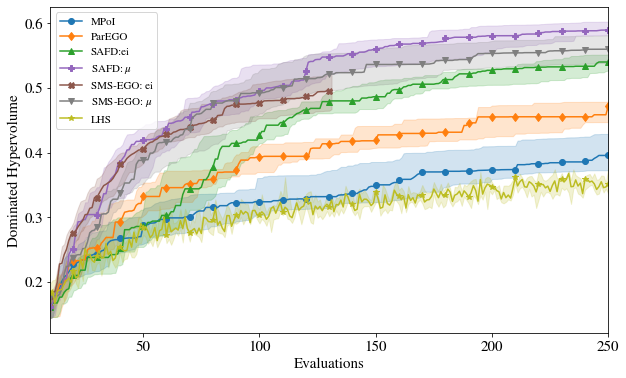

In [16]:
fig_hv = plt.figure(figsize=[10, 6])
ax_hv = fig_hv.gca()

cmap = cm.tab10
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

for result, color, marker, name, in zip(results, colors, markers, names):
    plot_measure(result, measure="hpv", axis=ax_hv, plot_individuals=False, label=name, color=color, marker=marker)
ax_hv.set_xlim([10, 250])
ax_hv.set_xlabel("Evaluations")
ax_hv.set_ylabel("Dominated Hypervolume")
ax_hv.legend()

In [17]:
try:
    fig_hv.savefig('./figures/hypervolume_wfg6_2obj_6dim.pdf', dpi="1200")  
    fig_hv.savefig('./figures/hypervolume_wfg6_2obj_6dim.png')  
except FileNotFoundError:
    os.makedirs("./figures")
    fig_hv.savefig('./figures/hypervolume_wfg6_2obj_6dim.pdf', dpi="1200")  
    fig_hv.savefig('./figures/hypervolume_wfg6_2obj_6dim.png')  

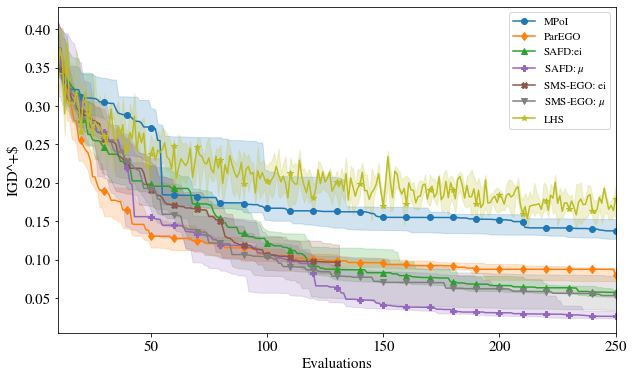

In [18]:
fig_igd = plt.figure(figsize=[10, 6])
ax_igd = fig_igd.gca()
for result, color, marker, name in zip(results, colors, markers, names):
    plot_measure(result, measure="igd", axis=ax_igd, plot_individuals=False, label=name, color=color, marker=marker)
ax_igd.set_xlim([10, 250])
ax_igd.set_xlabel("Evaluations")
ax_igd.set_ylabel("IGD^+$")
ax_igd.legend()

In [19]:
try:
    fig_igd.savefig('./figures/igd+_wfg6_2obj_6dim.pdf', dpi="1200")  
    fig_igd.savefig('./figures/igd+_wfg6_2obj_6dim.png')  
except FileNotFoundError:
    os.makedirs("./figures")
    fig_igd.savefig('./figures/igd+_wfg6_2obj_6dim.pdf', dpi="1200")  
    fig_igd.savefig('./figures/igd+_wfg6_2obj_6dim.png')  

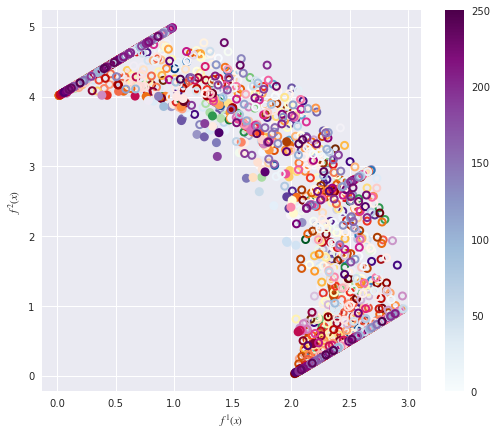

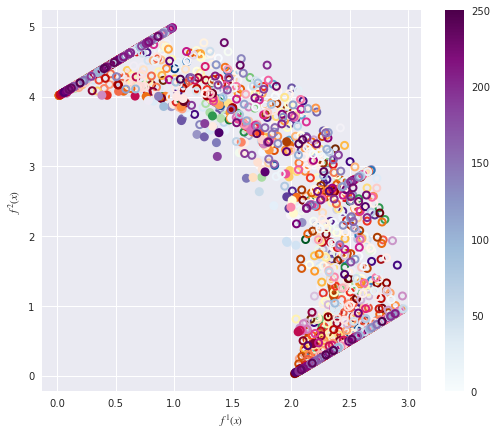

In [14]:
plot_all_pareto_2d(results[1])

In [17]:
if not pkl_loaded:
    outfile = open(filename,'wb')
    pickle.dump(results, outfile)
    outfile.close()

In [21]:
for result in results:
    print(result["errors"])
    print("\n\n")

[[], [], [], ['Error#01: Failed to find unique new solution at eval 116 seed:1'], [], [], ['Error#02: Took 2 attempts to find unique solution at eval 59 seed:8', 'Error#02: Took 2 attempts to find unique solution at eval 62 seed:8'], [], [], [], []]



[[], [], [], [], [], [], [], [], [], [], []]



[[], [], [], [], [], [], [], [], [], [], []]



[[], [], [], [], ['Error#02: Took 2 attempts to find unique solution at eval 151 seed:6'], [], [], [], [], [], []]



[['Error#02: Took 3 attempts to find unique solution at eval 125 seed:9', 'Error#02: Took 2 attempts to find unique solution at eval 145 seed:9', 'Error#02: Took 2 attempts to find unique solution at eval 180 seed:9', 'Error#02: Took 2 attempts to find unique solution at eval 181 seed:9', 'Error#02: Took 2 attempts to find unique solution at eval 214 seed:9', 'Error#02: Took 2 attempts to find unique solution at eval 229 seed:9', 'Error#02: Took 2 attempts to find unique solution at eval 236 seed:9', 'Error#02: Took 2 attempts 

In [15]:
results[1]["errors"]

[[], [], [], [], [], [], [], [], [], [], []]

In [16]:
sys.getsizeof(results)

136